# **데이터 불러오기**

In [72]:
import pandas as pd
import numpy as np
from time import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from tensorflow.keras.layers import Dropout,Flatten
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()

early_stopping = EarlyStopping()

train_features=pd.read_csv('train_features.csv')
train_labels=pd.read_csv('train_labels.csv')
test=pd.read_csv('test_features.csv')
submission=pd.read_csv('sample_submission.csv')

train_features = train_features.assign(loc = lambda x: np.hypot(np.hypot(x['gy_x'],x['gy_y']),x['gy_z']))
train_features = train_features.assign(acc = lambda x: np.hypot(np.hypot(x['acc_x'],x['acc_y']),x['acc_z']))
train_features = train_features.assign(move = lambda x: np.sqrt(np.sqrt(x['gy_x']**2+x['acc_x']**2)**2+np.sqrt(x['gy_y']**2+x['acc_y']**2)**2+np.sqrt(x['gy_z']**2+x['acc_z']**2)**2))

test = test.assign(loc = lambda x: np.hypot(np.hypot(x['gy_x'],x['gy_y']),x['gy_z']))
test = test.assign(acc = lambda x: np.hypot(np.hypot(x['acc_x'],x['acc_y']),x['acc_z']))
test = test.assign(move = lambda x: np.sqrt(np.sqrt(x['gy_x']**2+x['acc_x']**2)**2+np.sqrt(x['gy_y']**2+x['acc_y']**2)**2+np.sqrt(x['gy_z']**2+x['acc_z']**2)**2))
start = time()
train_features = train_features[['id','time','loc','acc','move']]
test = test[['id','time','loc','acc','move']]
ms = MinMaxScaler()
train_features = pd.DataFrame(ms.fit_transform(train_features))


In [60]:
x_train = []

train_features.shape

for uid in tqdm(train_features['id'].unique()):
    temp = np.array(train_features[train_features['id'] == uid].iloc[:,2:], np.float32).T
    x_train.append(temp)

x_train = np.array(x_train, np.float32)

x_test = []

for uid in tqdm(test['id'].unique()):
    temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32).T
    x_test.append(temp)

x_test = np.array(x_test, np.float32)

x_train = x_train[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]

def aug(data, uid, shift = 0):
    shift_data = np.roll(data, shift, axis=2)
    
for _ in range(10):
    aug(x_train, 0, int(random.random()*600))


100%|██████████| 782/782 [00:00<00:00, 1073.33it/s]


In [62]:
X=tf.reshape(x_train,[-1, 600,3])
y = tf.keras.utils.to_categorical(train_labels['label']) 

In [67]:
knn_model = KNeighborsRegressor()
svr_model = SVR()
lr_model = LinearRegression()
rf_model = RandomForestRegressor()
lgb_model = LGBMRegressor()

In [74]:
ms = MinMaxScaler()
X = pd.DataFrame(ms.fit_transform(X))

cross_score_knn = cross_val_score(knn_model, X, y, scoring='neg_mean_squared_error', cv=5)
cross_score_lr = cross_val_score(lr_model, X, y, scoring='neg_mean_squared_error', cv=5)
cross_score_svr = cross_val_score(svr_model, X, y, scoring='neg_mean_squared_error', cv=5)
cross_score_rf = cross_val_score(rf_model, X, y, scoring='neg_mean_squared_error', cv=5)
cross_score_lgb = cross_val_score(lgb_model, X, y, scoring='neg_mean_squared_error', cv=5)


r_score_knn = np.sqrt(-cross_score_knn)
r_score_lr = np.sqrt(-cross_score_lr)
r_score_svr = np.sqrt(-cross_score_svr)
r_score_rf = np.sqrt(-cross_score_rf)
r_score_lgb = np.sqrt(-cross_score_lgb)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [ ]:
print("KNN score :",r_score_knn, " / KNN mean score", r_score_knn.mean())
print("LR score :",r_score_lr, " / LR mean score", r_score_lr.mean())
print("SVR score :",r_score_svr, " / SVR mean score", r_score_svr.mean())
print("RF score :",r_score_rf, " / SVR mean score", r_score_rf.mean())
print("LGB score :",r_score_lgb, " / SVR mean score", r_score_lgb.mean())

In [63]:
#가벼운 모델 생성
model = Sequential()
model.add(LSTM(64))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(61, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
history = model.fit(X,y, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 3s 65ms/step - loss: 3.5605 - accuracy: 0.2772 - val_loss: 2.7173 - val_accuracy: 0.4976
Epoch 2/100
20/20 [==============================] - 1s 47ms/step - loss: 2.9693 - accuracy: 0.4684 - val_loss: 2.6441 - val_accuracy: 0.4976
Epoch 3/100
20/20 [==============================] - 1s 43ms/step - loss: 2.8302 - accuracy: 0.4812 - val_loss: 2.5441 - val_accuracy: 0.4976
Epoch 4/100
20/20 [==============================] - 1s 43ms/step - loss: 2.6742 - accuracy: 0.4879 - val_loss: 2.4629 - val_accuracy: 0.5120
Epoch 5/100
20/20 [==============================] - 1s 44ms/step - loss: 2.5352 - accuracy: 0.5014 - val_loss: 2.3375 - val_accuracy: 0.5200
Epoch 6/100
20/20 [==============================] - 1s 44ms/step - loss: 2.4805 - accuracy: 0.4962 - val_loss: 2.3042 - val_accuracy: 0.5184
Epoch 7/100
20/20 [==============================] - 1s 47ms/step - loss: 2.4440 - accuracy: 0.5093 - val_loss: 2.1998 - val_accuracy: 0.5360
Epoch 


When hidden layers are 2, Elapse training time : 131.06125855445862 seconds

98/98 [==============================] - 1s 11ms/step - loss: 1.1189 - accuracy: 0.6864

Loss : 1.11887
Accuracy : 68.64%
When hidden layers are 2, Elapse test time : 1.1456797122955322 seconds


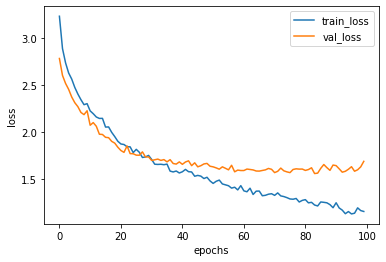

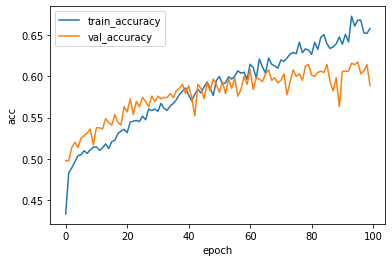

In [58]:
print(f'\nWhen hidden layers are 2, Elapse training time : {time() - start} seconds\n')
start = time()
loss_and_metrics = model.evaluate(X, y)
print(f'\nLoss : {loss_and_metrics[0]:.6}')
print(f'Accuracy : {loss_and_metrics[1]*100:.6}%')
print(f'When hidden layers are 2, Elapse test time : {time() - start} seconds')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [52]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600,9])
prediction=model.predict(test_X)
submission.iloc[:,1:]=prediction
submission.to_csv('submission.csv', index=False)